# Implementation of Machine Learning Algorithms on Ames Housing Dataset (Regression Task)

This notebook implements Machine Learning algorithms for regression on the Ames Housing Dataset. The dataset has been provided by Kaggle. https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

## 1. Linear Regression
We begin by first implementing linear regression.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, ShuffleSplit, learning_curve, validation_curve
from sklearn.preprocessing import MinMaxScaler
from Utils import load_dataset, plot_curve, preprocess, get_multiple_estimates, plot_learning_curve, plot_validation_curve
from LinearRegression import LinearRegression
from KNN import KNN
from ImputationTransform import ImputationTransform
%matplotlib inline

In [2]:
train, test = load_dataset()
print("initial train data size (with label)", train.shape)

train_X, train_y = preprocess(train, impute_data=True, normalize_data=False)
print("updated train data size (without label)", train_X.shape)

initial train data size (with label) (1460, 81)
updated train data size (without label) (1460, 328)


### Gradient Descent
Below, we see the effect of varying learning rate on Gradient Descent Algorithm. As learning rate increases, the convergence is reached faster - i.e. at earlier iteration. However, if we increase learning rate too much, the cost function starts increasing instead of decreasing - i.e. Gradient descent does not work as expected.

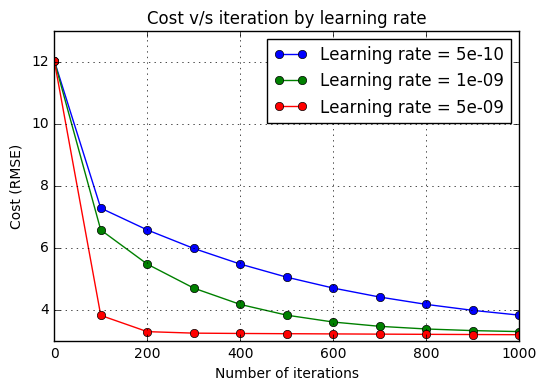

In [4]:
learning_rate = [0.0000000005, 0.000000001, 0.000000005]
max_iter = 1000
iteration_threshold = 100

cost_by_lr, iterations, plotlabels = get_multiple_estimates(train_X, train_y, learning_rate, 
                                                            max_iter, iteration_threshold, reg_strength=0, 
                                                            regularization="Ridge", method="GD", 
                                                            plot_by_lr=True, plot_by_mb=False)

plot_curve(Ylist=cost_by_lr, Xlist=iterations, title="Cost v/s iteration by learning rate", 
           xlabel="Number of iterations", ylabel="Cost (RMSE)", plotlabels=plotlabels)

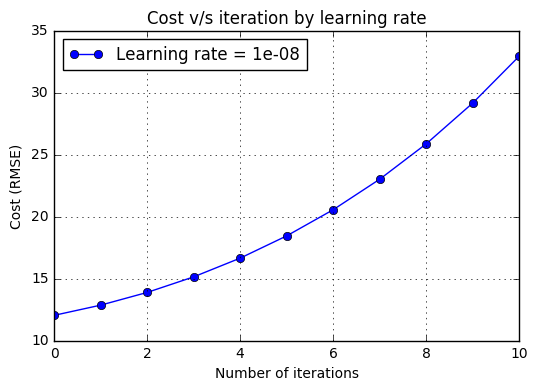

In [5]:
learning_rate = [0.00000001]
max_iter = 10
iteration_threshold = 1

cost_by_lr, iterations, plotlabels = get_multiple_estimates(train_X, train_y, learning_rate, 
                                                            max_iter, iteration_threshold, reg_strength=0, 
                                                            regularization="Ridge", method="GD", 
                                                            plot_by_lr=True, plot_by_mb=False)
    
plot_curve(Ylist=cost_by_lr, Xlist=iterations, title="Cost v/s iteration by learning rate", 
           xlabel="Number of iterations", ylabel="Cost (RMSE)", plotlabels=plotlabels)

### Stochastic Gradient Descent
Instead of looking at full data to compute the gradient, stochastic gradient descent (SGD) looks at a random training example. In many cases, based on the dataset size, it is not feasible to run the gradient descent. SGD often reaches the minima in fewer iterations over the dataset. Below, we see SGD in action.

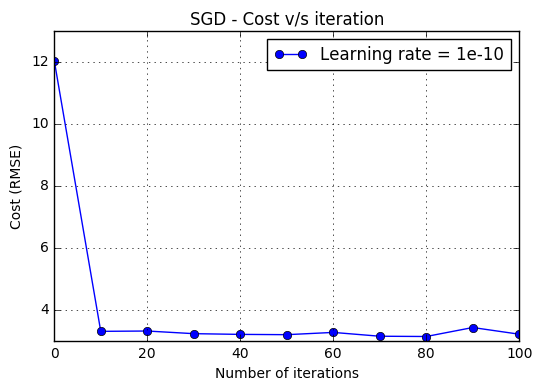

In [6]:
learning_rate = [0.0000000001]
max_iter = 100
iteration_threshold = 10

cost_by_lr, iterations, plotlabels = get_multiple_estimates(train_X, train_y, learning_rate, 
                                                            max_iter, iteration_threshold, reg_strength=0, 
                                                            regularization="Ridge", method="SGD", 
                                                            plot_by_lr=True, plot_by_mb=False)

plot_curve(Ylist=cost_by_lr, Xlist=iterations, title="SGD - Cost v/s iteration", 
           xlabel="Number of iterations", ylabel="Cost (RMSE)", plotlabels=plotlabels)

### Minibatch Gradient Descent
In the SGD graph above, we notice that how approximation of the gradient can lead to increase in cost sometimes. This is a trade-off between reaching minima faster but cost values not being smooth over iterations. To balance this trade-off, we can use Minibatch Gradient Descent which is a more general case for stochastic gradient descent - i.e. instead of taking 1 training example to compute gradient, we take 'b' examples. Higher the batch size, closer the results to gradient descent, and vice-versa for stochastic gradient descent. In the graph below, notice how with larger batch size, the cost curve is smoother but with smalller batch size, minima is reached in lower iterations.

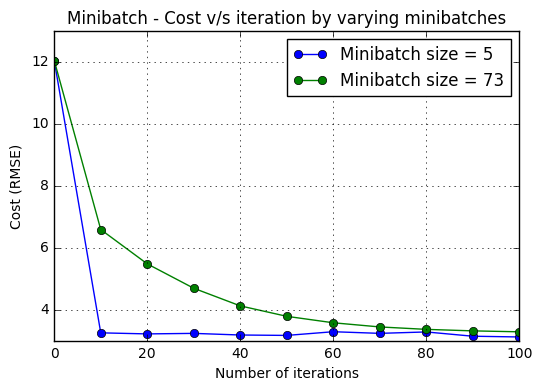

In [7]:
learning_rate = 0.0000000005
max_iter = 100
iteration_threshold = 10
minibatch_size = [5, 73]

cost_by_lr, iterations, plotlabels = get_multiple_estimates(train_X, train_y, learning_rate, 
                                                            max_iter, iteration_threshold, reg_strength=0, 
                                                            regularization="Ridge", method="Minibatch", 
                                                            minibatch_size=minibatch_size, 
                                                            plot_by_lr=False, plot_by_mb=True)

plot_curve(Ylist=cost_by_lr, Xlist=iterations, title="Minibatch - Cost v/s iteration by varying minibatches", 
           xlabel="Number of iterations", ylabel="Cost (RMSE)", plotlabels=plotlabels)

### Comparing variations of Gradient Descent
Here, we compare the three algorithms discussed above by looking at thee results in one graph. We can see that Gradient Descent shows a smooth descent of the cost value, but requires more iterations over the dataset. SGD reaches the minima in much less iterations but is very 'jumpy'. Finally, minibatch GD balances them by being faster than GD but less jumpy than SGD.

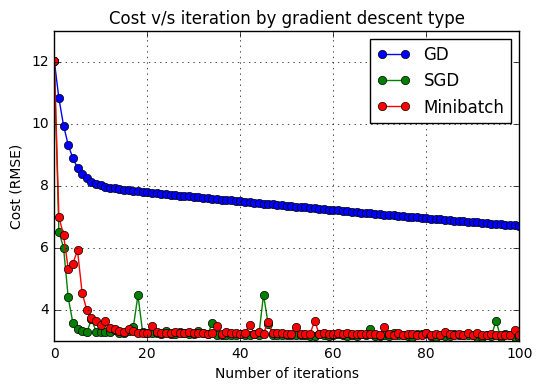

In [8]:
learning_rate = [0.0000000009, 0.0000000001, 0.0000000009]
max_iter = 100
iteration_threshold = 1
plotlabels = ['GD', 'SGD', 'Minibatch']

cost_by_lr, iterations, plotlabels = get_multiple_estimates(train_X, train_y, learning_rate, max_iter, 
                                                            iteration_threshold, reg_strength=0, 
                                                            regularization="Ridge", minibatch_size=20, 
                                                            plotlabels=plotlabels, plot_by_lr=False, 
                                                            plot_by_mb=False)

plot_curve(Ylist=cost_by_lr, Xlist=iterations, title="Cost v/s iteration by gradient descent type", 
           xlabel="Number of iterations", ylabel="Cost (RMSE)", plotlabels=plotlabels)

### Analysis
#### Learning Curves
Now, we move on to analyze if linear regression with our set of features is a 'good' algorithm for this dataset. Specifically, we will look for evidence of underfitting (high bias) or overfitting (high variance) by plotting the learning curve, i.e. measuring mean squared error on training and a held out validation set with varying size of training data.  

In [16]:
train, test = load_dataset()
print("initial train data size (with label)", train.shape)

train_X, train_y = preprocess(train, impute_data=False, normalize_data=False)
print("updated train data size (without label)", train_X.shape)

# use scikit's pipeline functionality to chain pre-processing steps to avoid leakage
estimators = [('impute', ImputationTransform()), ('scale', MinMaxScaler()), 
                                          ('linRegress', LinearRegression(learning_rate=0.00008, cost_threshold=0.0001))]
pipeline = Pipeline(estimators)

initial train data size (with label) (1460, 81)
updated train data size (without label) (1460, 328)


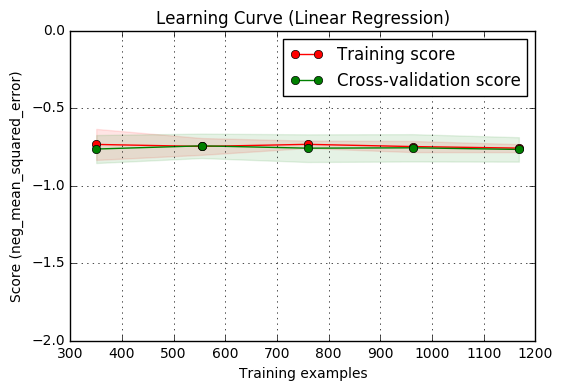

In [17]:
cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=3)
plot_learning_curve(estimator=pipeline, title="Learning Curve (Linear Regression)", X=train_X, y=train_y, ylim=(-2, 0), cv=cv, 
                    train_sizes=np.linspace(.3, 1.0, 5), scoring="neg_mean_squared_error")

Looking at the above curve, we can see that increasing dataset size is not improving the mean squared error on the validation set. The performance on training and validation set is very close to each other. We suffer from a 'high bias' or underfitting problem. In other words, either the algorithm or the features are too simplistic to achieve good training and validation performance.

#### Validation Curves
The learning curve from above suggests that we have a 'high bias' problem. This should mean that increasing strength of regularization should not help much in achieving higher validation set performance because regularization further increases the bias. Here, we plot the validation curve - i.e. vary hyperparameter strength of regularization and measure the mean squared error.

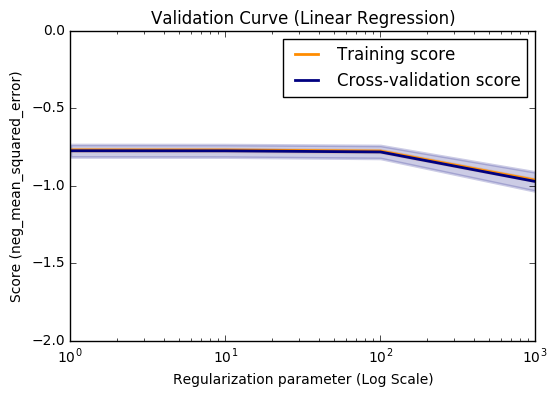

In [18]:
param_range = [1, 10, 100, 1000]
plot_validation_curve(
        estimator=pipeline, title="Validation Curve (Linear Regression)", X=train_X, y=train_y, 
    param_name="linRegress__reg_strength", param_range=param_range, cv=3, scoring="neg_mean_squared_error", 
    ylim=(-2, 0))

#### Grid Search
As predicted by the analysis of learning curve, increasing strength of regularization does not improve model performance. We will do a fine tuned grid search below to find the best hyperparameter. Looking at the results, we find that for the given set of features, a linear regression model with no regularization performs best on the validation set. To improve the model performance, we will either have to use a more complex algorithm or more complex set of features.

In [19]:
param_grid = dict(linRegress__reg_strength=[0, 1, 3, 10])
grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, 
                           return_train_score=True)

grid_search.fit(train_X, train_y)

print("Mean train scores: " + str(grid_search.cv_results_['mean_train_score']))
print("Mean test scores: " + str(grid_search.cv_results_['mean_test_score']))

Mean train scores: [-0.76732027 -0.76740482 -0.76751625 -0.76799886]
Mean test scores: [-0.77287349 -0.77297569 -0.77309258 -0.77359543]


## 2. k-Nearest Neighbor Regression
We now move onto implementing k-Nearest Neighbor Regression on the given dataset.

In [2]:
train, test = load_dataset()
print("initial train data size (with label)", train.shape)

train_X, train_y = preprocess(train, impute_data=False, normalize_data=False)
print("updated train data size (without label)", train_X.shape)

# use scikit's pipeline functionality to chain pre-processing steps to avoid leakage
estimators = [('impute', ImputationTransform()), ('scale', MinMaxScaler()), 
                                          ('kNN', KNN())]
pipeline = Pipeline(estimators)

initial train data size (with label) (1460, 81)
updated train data size (without label) (1460, 328)


#### Learning Curves
Learning curve for kNN algorithm with k=1 indicates slight evidence of overfitting (high variance). Model performance improves with increase in the training data size. Alternatively, model performance should also improve with decreasing variance by increasing number of nearest neighbors (k).

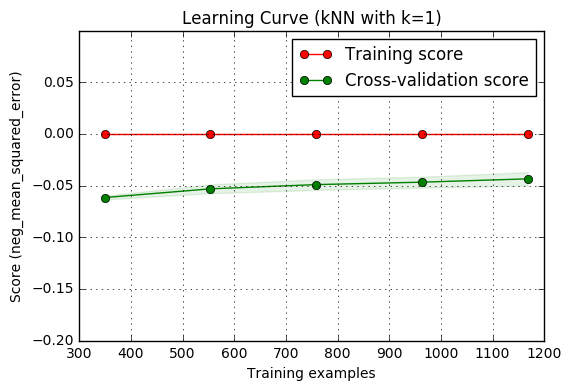

In [4]:
cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=3)
plot_learning_curve(estimator=pipeline, title="Learning Curve (kNN with k=1)", X=train_X, y=train_y, 
                    ylim=(-0.2, 0.1), cv=cv, train_sizes=np.linspace(.3, 1.0, 5), scoring="neg_mean_squared_error")

#### Validation Curves
The learning curve above indicates slight evidence of overfitting - so we would expect increasing number of nearest neighbors to increase model performance. Indeed, we find that k=10 performs better on the validation set than k=1. We can also see that both training and validation scores are closer to each other at k=10.

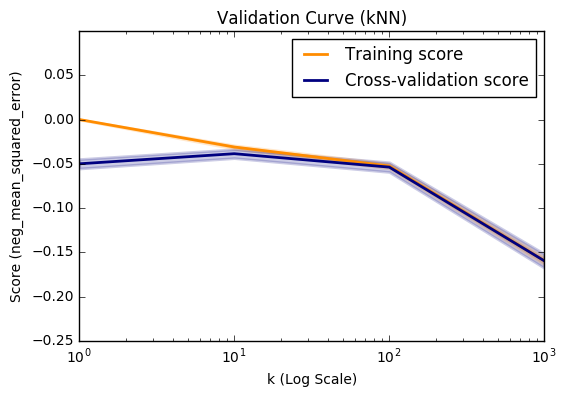

In [3]:
param_range = [1, 10, 100, 1000]
plot_validation_curve(
        estimator=pipeline, title="Validation Curve (kNN)", X=train_X, y=train_y, 
    param_name="kNN__k", param_range=param_range, cv=3, scoring="neg_mean_squared_error", 
    ylim=(-0.25, 0.1), xlabel="k")